# Malware Detection Feature Analysis

This notebook extracts and analyzes the most relevant features from the EMBER dataset for malware detection in PE files.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
from collections import defaultdict

# Set style for visualizations
sns.set_theme()
plt.style.use('default')

In [62]:
def extract_malware_features(data):
    """Extract relevant features for malware detection with improved section analysis"""
    features = {}
    
    try:
        # Basic file information with type conversion and validation
        general = data.get('general', {})
        size = float(general.get('size', 0))
        vsize = float(general.get('vsize', 0))
        features['file_size'] = max(0.0, size)  # Ensure non-negative
        features['virtual_size'] = max(0.0, vsize)  # Ensure non-negative
        features['size_ratio'] = vsize / size if size > 0 else 0.0
        
        # Convert boolean flags to integers with validation
        for flag in ['has_debug', 'has_signature', 'has_tls', 'has_resources']:
            features[flag] = int(bool(general.get(flag, False)))
        
        # Count features with validation
        features['num_imports'] = max(0, int(general.get('imports', 0)))
        features['num_exports'] = max(0, int(general.get('exports', 0)))
        
        # Section information with improved parsing
        section_data = data.get('section', {})
        sections = section_data.get('sections', [])
        num_sections = len(sections)
        section_entropies = []
        section_sizes = []
        section_virtual_sizes = []
        executable_sections = 0
        writable_sections = 0
        suspicious_count = 0
        
        for section in sections:
            try:
                # Handle both string and dictionary section formats
                if isinstance(section, str):
                    # Parse string format (key=value;key=value;...)
                    parts = section.split(';')
                    section_info = {}
                    for part in parts:
                        if '=' in part:
                            key, value = part.split('=', 1)
                            section_info[key.strip()] = value.strip()
                else:
                    section_info = section
                
                # Extract section properties
                entropy = float(section_info.get('entropy', 0))
                sect_size = float(section_info.get('size', 0))
                sect_vsize = float(section_info.get('vsize', 0))
                characteristics = section_info.get('characteristics', '')
                name = section_info.get('name', '').lower()
                
                # Validate and collect metrics
                if 0 <= entropy <= 8.0:
                    section_entropies.append(entropy)
                if sect_size > 0:
                    section_sizes.append(sect_size)
                if sect_vsize > 0:
                    section_virtual_sizes.append(sect_vsize)
                
                # Check section characteristics
                if 'IMAGE_SCN_MEM_EXECUTE' in characteristics:
                    executable_sections += 1
                if 'IMAGE_SCN_MEM_WRITE' in characteristics:
                    writable_sections += 1
                
                # Check for suspicious characteristics
                is_suspicious = False
                if entropy > 7.0:  # High entropy
                    is_suspicious = True
                if sect_size > 0 and sect_vsize > sect_size * 10:  # Large virtual size
                    is_suspicious = True
                if name in {'.text', '.data', '.rdata'} and entropy > 7.5:  # Unusual entropy in standard sections
                    is_suspicious = True
                if 'IMAGE_SCN_MEM_WRITE' in characteristics and 'IMAGE_SCN_MEM_EXECUTE' in characteristics:  # RWX section
                    is_suspicious = True
                
                if is_suspicious:
                    suspicious_count += 1
                    
            except (ValueError, KeyError, AttributeError) as e:
                continue
        
        # Calculate section statistics
        features['num_sections'] = num_sections
        features['executable_sections'] = executable_sections
        features['writable_sections'] = writable_sections
        features['suspicious_sections'] = suspicious_count
        
        if section_entropies:
            features['avg_section_entropy'] = float(np.mean(section_entropies))
            features['max_section_entropy'] = float(max(section_entropies))
            features['min_section_entropy'] = float(min(section_entropies))
            features['std_section_entropy'] = float(np.std(section_entropies)) if len(section_entropies) > 1 else 0.0
        else:
            features['avg_section_entropy'] = 0.0
            features['max_section_entropy'] = 0.0
            features['min_section_entropy'] = 0.0
            features['std_section_entropy'] = 0.0
        
        # Calculate size statistics
        if section_sizes:
            features['avg_section_size'] = float(np.mean(section_sizes))
            features['max_section_size'] = float(max(section_sizes))
            features['total_section_size'] = float(sum(section_sizes))
        else:
            features['avg_section_size'] = 0.0
            features['max_section_size'] = 0.0
            features['total_section_size'] = 0.0
        
        # String features with validation
        str_data = data.get('strings', {})
        features['num_strings'] = max(0, int(str_data.get('numstrings', 0)))
        features['string_entropy'] = max(0.0, min(8.0, float(str_data.get('entropy', 0))))
        features['num_paths'] = max(0, int(str_data.get('paths', 0)))
        features['num_urls'] = max(0, int(str_data.get('urls', 0)))
        features['num_registry'] = max(0, int(str_data.get('registry', 0)))
        features['num_MZ'] = max(0, int(str_data.get('MZ', 0)))
        
        # Import features with extended API checking
        suspicious_imports = 0
        network_imports = 0
        crypto_imports = 0
        process_imports = 0
        
        suspicious_apis = {
            # Process manipulation
            'createprocess', 'createremotethread', 'createthread', 'ntcreateprocess',
            'resumethread', 'winexec', 'shellexecute',
            # Memory operations
            'virtualalloc', 'virtualallocex', 'virtualprotect', 'writeprocessmemory',
            'readprocessmemory', 'heapalloc',
            # Registry operations
            'regcreatekey', 'regsetvalue', 'regdeletekey',
            # File operations
            'createfile', 'writefile', 'copyfile', 'deletefile',
            # DLL handling
            'loadlibrary', 'getprocaddress', 'getmodulehandle',
            # Injection/Hooking
            'setwindowshookex', 'createfilemapping',
            # Anti-debugging
            'isdebuggerpresent', 'checkremotedebuggerpresent', 'ntsetinformationthread',
            # System info
            'getsysteminformation', 'enumprocesses'
        }
        
        network_apis = {
            'socket', 'connect', 'send', 'recv', 'internetopen', 'internetconnect',
            'httpopenrequest', 'httpsendrequesta', 'gethostbyname', 'wsastartup'
        }
        
        crypto_apis = {
            'cryptacquirecontext', 'cryptgenkey', 'crypthash', 'cryptencrypt',
            'cryptdecrypt', 'ssleay', 'openssl'
        }
        
        if 'imports' in data:
            for dll, functions in data['imports'].items():
                if not isinstance(functions, list):
                    continue
                dll = dll.lower()
                for func in functions:
                    if not isinstance(func, str):
                        continue
                    func = func.lower()
                    
                    # Count suspicious APIs
                    if any(api in func for api in suspicious_apis):
                        suspicious_imports += 1
                    # Count network-related APIs
                    if any(api in func for api in network_apis) or any(lib in dll for lib in ['wininet', 'ws2_32', 'wsock32']):
                        network_imports += 1
                    # Count crypto-related APIs
                    if any(api in func for api in crypto_apis) or any(lib in dll for lib in ['crypt32', 'cryptsp', 'advapi32']):
                        crypto_imports += 1
                    # Count process-related APIs
                    if 'process' in func or 'process' in dll:
                        process_imports += 1
        
        features['suspicious_imports'] = suspicious_imports
        features['network_imports'] = network_imports
        features['crypto_imports'] = crypto_imports
        features['process_imports'] = process_imports
        
        # Statistical features with validation
        if 'byteentropy' in data and isinstance(data['byteentropy'], (list, np.ndarray)):
            byte_entropy = np.array(data['byteentropy'], dtype=float)
            features['byte_entropy_mean'] = float(np.mean(byte_entropy))
            features['byte_entropy_std'] = float(np.std(byte_entropy))
        else:
            features['byte_entropy_mean'] = 0.0
            features['byte_entropy_std'] = 0.0
            
        if 'histogram' in data and isinstance(data['histogram'], (list, np.ndarray)):
            histogram = np.array(data['histogram'], dtype=float)
            features['histogram_mean'] = float(np.mean(histogram))
            features['histogram_std'] = float(np.std(histogram))
        else:
            features['histogram_mean'] = 0.0
            features['histogram_std'] = 0.0
            
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        # Initialize all features to 0 if extraction fails
        feature_keys = [
            'file_size', 'virtual_size', 'size_ratio',
            'has_debug', 'has_signature', 'has_tls', 'has_resources',
            'num_imports', 'num_exports', 'num_sections',
            'executable_sections', 'writable_sections', 'suspicious_sections',
            'avg_section_entropy', 'max_section_entropy', 'min_section_entropy', 'std_section_entropy',
            'avg_section_size', 'max_section_size', 'total_section_size',
            'num_strings', 'string_entropy', 'num_paths', 'num_urls', 'num_registry', 'num_MZ',
            'suspicious_imports', 'network_imports', 'crypto_imports', 'process_imports',
            'byte_entropy_mean', 'byte_entropy_std', 'histogram_mean', 'histogram_std'
        ]
        for key in feature_keys:
            features[key] = 0.0
    
    return features

In [63]:
def load_and_process_samples(file_pattern, max_samples=1000):
    """Load and process samples from JSONL files ensuring balanced labels"""
    features_list = []
    benign_count = 0
    malware_count = 0
    max_per_class = max_samples // 2  # Split samples equally between classes
    
    try:
        for file_path in sorted(glob.glob(file_pattern)):
            print(f"Processing {file_path}...")
            
            with open(file_path, 'r') as f:
                for line in f:
                    try:
                        data = json.loads(line)
                        label = int(data.get('label', -1))
                        
                        # Skip unlabeled samples
                        if label == -1:
                            continue
                            
                        # Check if we need more samples of this class
                        if (label == 0 and benign_count >= max_per_class) or \
                           (label == 1 and malware_count >= max_per_class):
                            continue
                        
                        features = extract_malware_features(data)
                        features['label'] = label
                        features_list.append(features)
                        
                        # Update counts
                        if label == 0:
                            benign_count += 1
                        else:
                            malware_count += 1
                        
                        total_samples = benign_count + malware_count
                        if total_samples % 100 == 0:
                            print(f"Processed {total_samples} samples (Benign: {benign_count}, Malware: {malware_count})...")
                        
                        # Check if we have enough samples of both classes
                        if benign_count >= max_per_class and malware_count >= max_per_class:
                            break
                            
                    except Exception as e:
                        print(f"Error processing sample: {str(e)}")
                        continue
                
                # Check if we have enough samples of both classes
                if benign_count >= max_per_class and malware_count >= max_per_class:
                    break
                    
    except Exception as e:
        print(f"Error reading files: {str(e)}")
    finally:
        print(f"\nFinal sample counts - Benign: {benign_count}, Malware: {malware_count}")
        return pd.DataFrame(features_list)

In [64]:
# Load and process samples (increased sample size for better statistics)
print("Loading samples...")
df = load_and_process_samples('ember2018/train_features_*.jsonl', max_samples=10000)

# Convert all columns to numeric type and handle any conversion errors
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Remove any samples where label is NaN or not in [0, 1]
df = df[df['label'].isin([0, 1])]

# Fill any NaN values with 0
df = df.fillna(0)

# Validate data types and ranges
print("\nDataFrame info:")
print(df.info())

print("\nFeature DataFrame shape:", df.shape)
print("\nFeature names:")
print(df.columns.tolist())

# Show basic statistics
print("\nFeature statistics:")
print(df.describe())

Loading samples...
Processing ember2018\train_features_0.jsonl...
Processed 100 samples (Benign: 100, Malware: 0)...
Processed 200 samples (Benign: 200, Malware: 0)...
Processed 300 samples (Benign: 300, Malware: 0)...
Processed 400 samples (Benign: 400, Malware: 0)...
Processed 200 samples (Benign: 200, Malware: 0)...
Processed 300 samples (Benign: 300, Malware: 0)...
Processed 400 samples (Benign: 400, Malware: 0)...
Processed 500 samples (Benign: 500, Malware: 0)...
Processed 600 samples (Benign: 600, Malware: 0)...
Processed 700 samples (Benign: 700, Malware: 0)...
Processed 500 samples (Benign: 500, Malware: 0)...
Processed 600 samples (Benign: 600, Malware: 0)...
Processed 700 samples (Benign: 700, Malware: 0)...
Processed 800 samples (Benign: 800, Malware: 0)...
Processed 900 samples (Benign: 900, Malware: 0)...
Processed 1000 samples (Benign: 1000, Malware: 0)...
Processed 800 samples (Benign: 800, Malware: 0)...
Processed 900 samples (Benign: 900, Malware: 0)...
Processed 1000

## Feature Analysis

Analyze the distribution of key features and their relationship with malware classification.


Label distribution:
label
0    5000
1    5000
Name: count, dtype: int64

Feature correlations with malware label:
label                  1.000000
has_tls                0.463196
max_section_entropy    0.456690
suspicious_sections    0.427078
std_section_entropy    0.343784
string_entropy         0.313749
avg_section_size       0.279187
total_section_size     0.274678
avg_section_entropy    0.252221
max_section_size       0.252196
network_imports        0.209662
histogram_std          0.184262
virtual_size           0.173795
num_sections           0.167882
process_imports        0.166440
byte_entropy_std       0.145080
crypto_imports         0.131751
histogram_mean         0.114014
file_size              0.114014
byte_entropy_mean      0.113998
suspicious_imports     0.110681
has_signature          0.100032
num_urls               0.089838
num_strings            0.085129
num_MZ                 0.067187
size_ratio             0.021284
num_registry          -0.030415
num_paths            

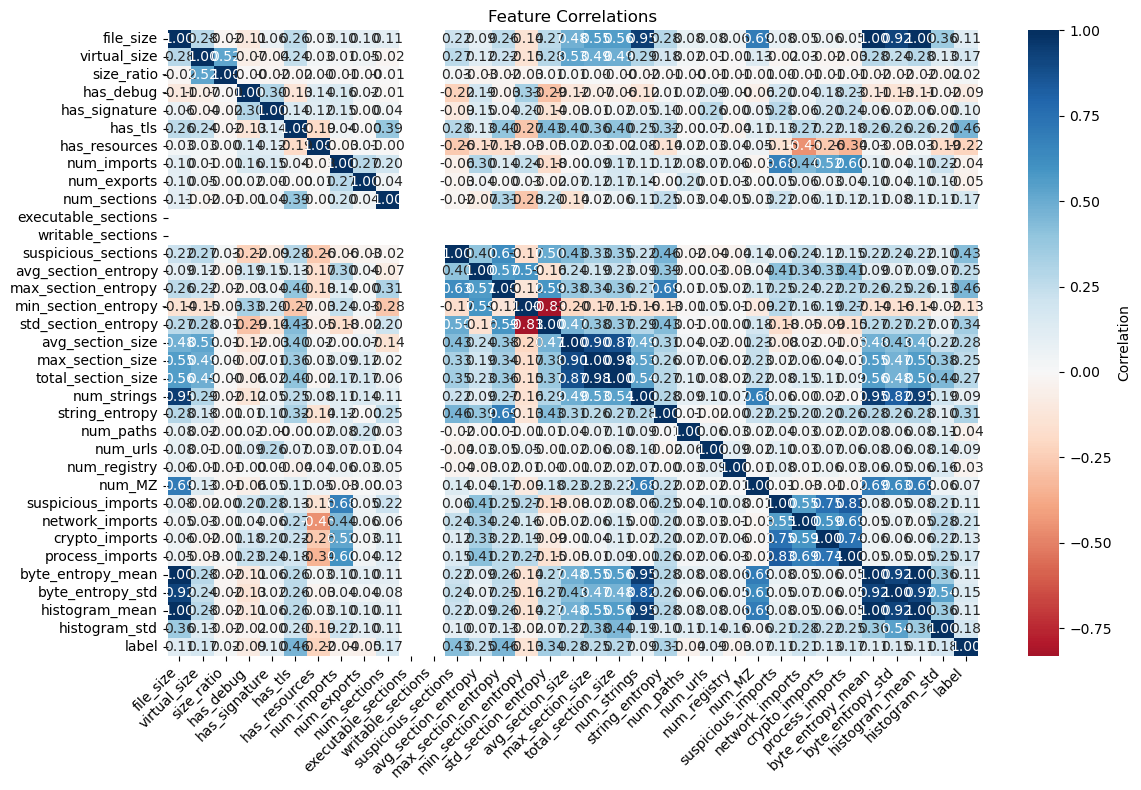

In [65]:
# Double check for any remaining NaN values
nan_counts = df.isna().sum()
if nan_counts.any():
    print("\nWarning: Found NaN values in features:")
    print(nan_counts[nan_counts > 0])
    df = df.fillna(0)  # Fill any remaining NaNs with 0

# Verify label distribution
print("\nLabel distribution:")
print(df['label'].value_counts())

# Calculate correlation with malware label
correlations = df.corr()['label'].sort_values(ascending=False)
print("\nFeature correlations with malware label:")
print(correlations)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='RdBu', center=0, annot=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

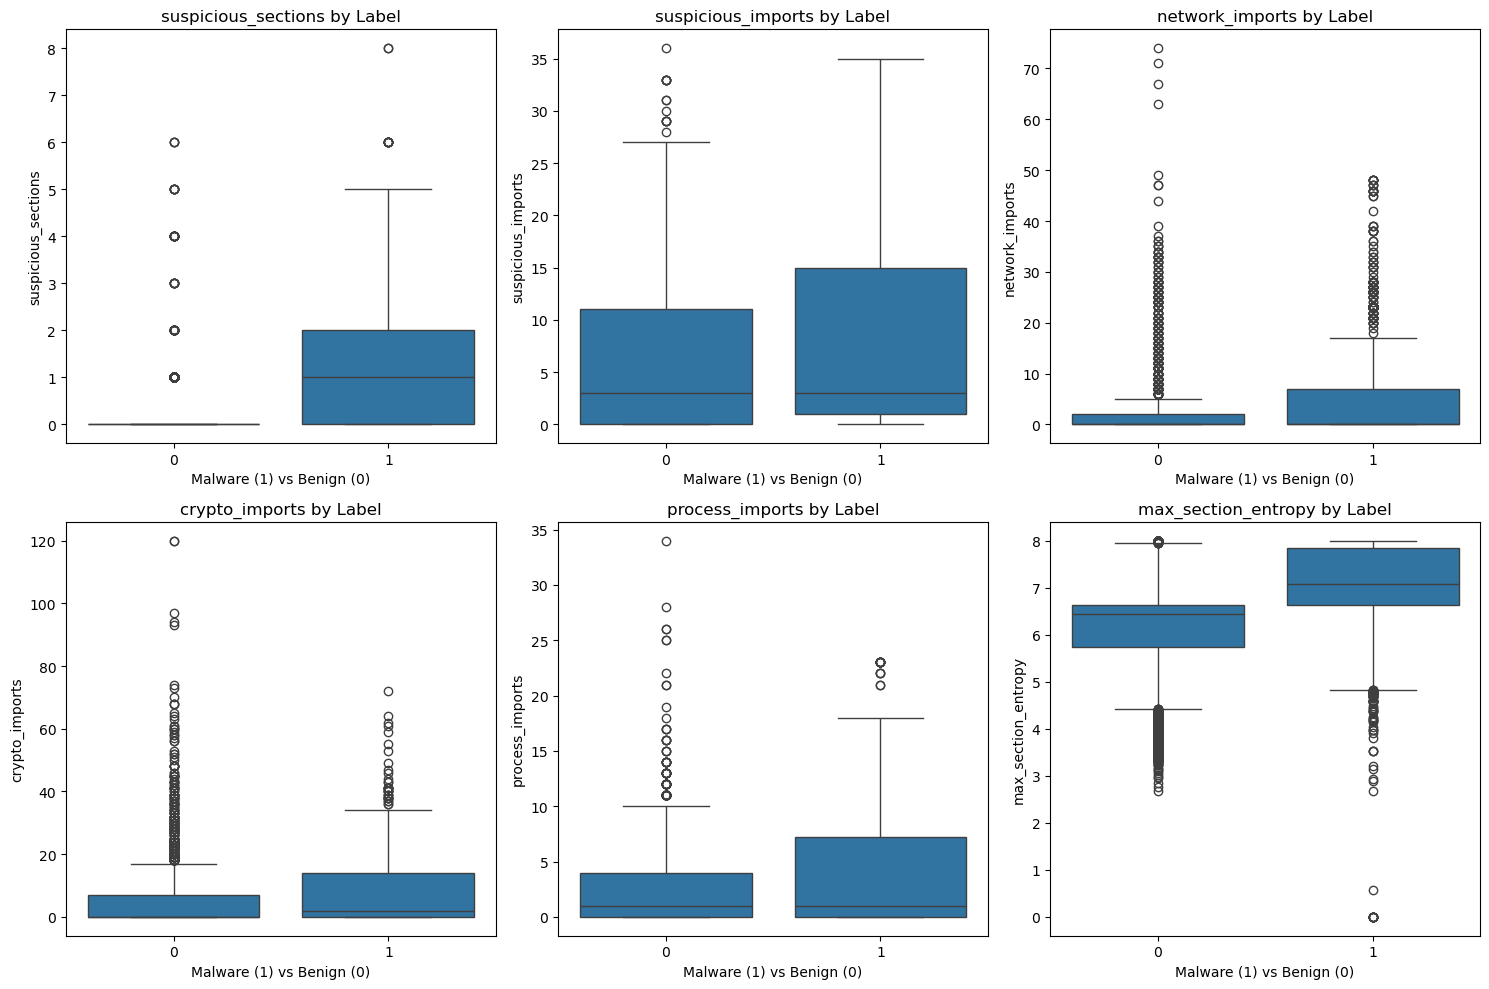

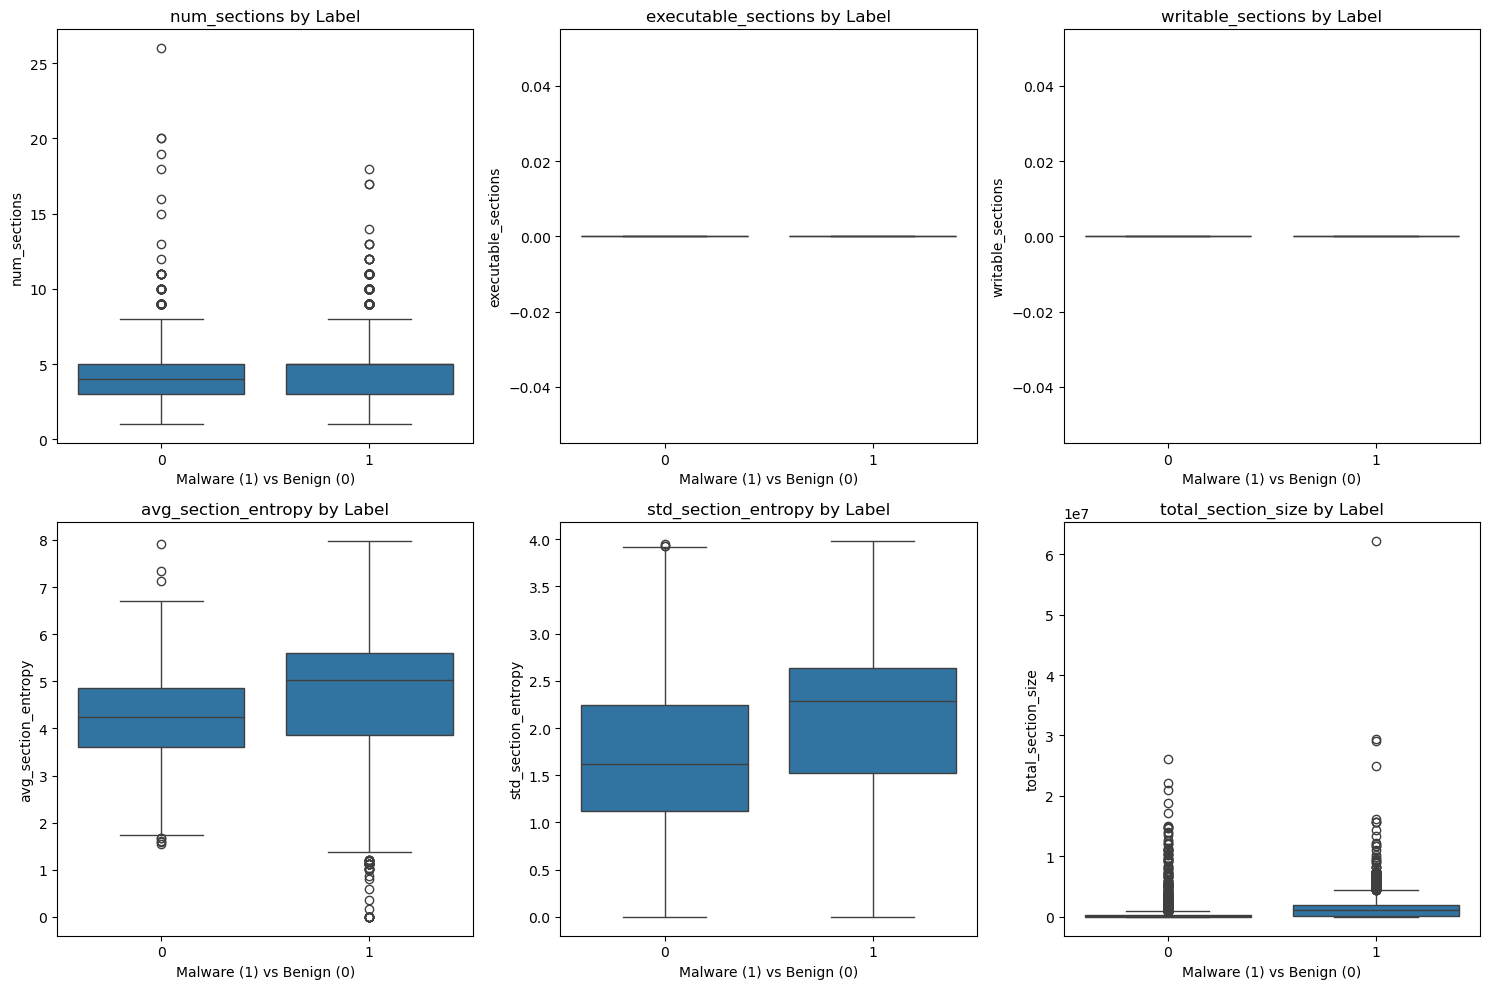

In [66]:
# Analyze malware-specific features
malware_features = [
    'suspicious_sections',
    'suspicious_imports',
    'network_imports',
    'crypto_imports',
    'process_imports',
    'max_section_entropy'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(malware_features):
    sns.boxplot(x='label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Label')
    axes[i].set_xlabel('Malware (1) vs Benign (0)')

plt.tight_layout()
plt.show()

# Plot section characteristics
section_features = [
    'num_sections',
    'executable_sections',
    'writable_sections',
    'avg_section_entropy',
    'std_section_entropy',
    'total_section_size'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(section_features):
    sns.boxplot(x='label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Label')
    axes[i].set_xlabel('Malware (1) vs Benign (0)')

plt.tight_layout()
plt.show()

In [ ]:
# Save important features for the interface
important_features = df[[
    'file_size', 'virtual_size', 'size_ratio',
    'suspicious_sections', 'suspicious_imports',
    'max_section_entropy', 'string_entropy',
    'num_urls', 'num_registry', 'num_MZ',
    'label'
]].copy()

# Save to CSV for the interface
important_features.to_csv('malware_detection_features.csv', index=False)
print("Saved important features to 'malware_detection_features.csv'")

# Display summary statistics
print("\nSummary statistics for important features:")
print(important_features.describe())

Saved important features to 'malware_detection_features.csv'

Summary statistics for important features:
          file_size  virtual_size    size_ratio  suspicious_sections  \
count  1.000000e+04  1.000000e+04  10000.000000         10000.000000   
mean   1.404682e+06  1.774208e+06      1.893411             0.565500   
std    2.952771e+06  6.287321e+06     15.214311             0.844619   
min    2.048000e+03  1.396000e+03      0.001344             0.000000   
25%    8.601600e+04  9.011200e+04      1.003657             0.000000   
50%    4.643840e+05  3.379200e+05      1.041667             0.000000   
75%    1.790976e+06  1.418240e+06      1.663420             1.000000   
max    9.066050e+07  4.053279e+08   1241.892109             8.000000   

       suspicious_imports  max_section_entropy  string_entropy     num_urls  \
count        10000.000000         10000.000000    10000.000000  10000.00000   
mean             6.422300             6.563520        5.729485      6.16310   
std      

: 